# Mean-Variance Optimization of a portfolio - risky and one riskfree asset. Demonstration of the two fund theorem

Here we will carry out the Mean Variance optimization for a portfolio containing one riskfree asset three risky assets. First we will find the return and risk of two stocks from their price data. Then we plot the return and risk of arbitrarily weighted portfolios. We then design a mean-variance optimization function and plot the efficient frontier using it.

The stocks we choose are:
Apple, Microsoft, Boeing, Berkshire Hathaway B and Proctor&Gamble

The riskfree asset is the 10 yr US Treasury bond. The annual rate of return is assumed to be 2.5 %, which is the average annual yield.

We also discuss the Sharpe optimal portfolio.



Instead of finding out the return and volatility from historical data, we take hypothetical return and volatility numbers. 

The three assets are Asset 1, Asset 2, Asset 3.

Their return vector is: [6.0, 2.0, 4.0] (annual returns in %)

The matrix of covariances is:

0.008 -0.002 0.004

-0.002 0.002 -0.002

0.004 -0.002 0.008


### Loading the necessary packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as sp
%matplotlib inline

In [62]:
num_assets = 4
iterations = 10000
ret_array = np.array([6.0, 2.0, 4.0])
cov_matrix = np.array([[0.008, -0.002, 0.003], [-0.002, 0.002, -0.002], [0.003, -0.002, 0.008]])

r_f = 2.5

In [63]:
pf_returns = []
pf_vol = []

In [64]:
for _ in range(iterations):
    weights = np.random.random(num_assets)
    weights /= sum(weights)
    weights_risky = weights[0:num_assets-1]
    pf_returns.append(np.sum(weights_risky*ret_array) + r_f*weights[num_assets-1])
    pf_vol.append((np.sqrt(np.dot(weights_risky.T,np.dot(cov_matrix,weights_risky))))*100)

In [65]:
portfolios = pd.DataFrame({'Return': pf_returns, 'Volatility': pf_vol})
portfolios.head()

,Return,Volatility
0,3.279603,4.449951
1,3.710529,3.020163
2,3.719725,3.012667
3,3.612151,3.913108
4,2.654101,2.259884


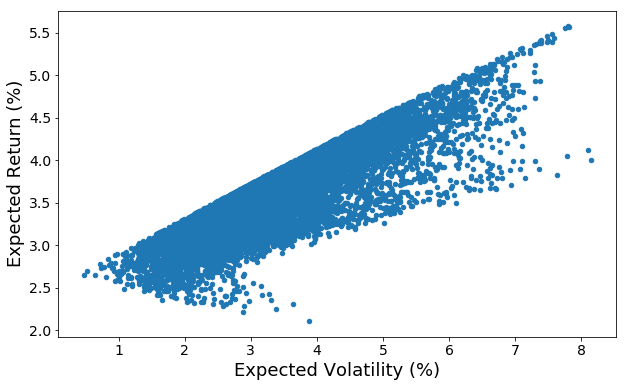

In [66]:
portfolios.plot(x='Volatility', y='Return', kind='scatter', figsize=(10, 6));
plt.xlabel('Expected Volatility (%)', size = 18)
plt.ylabel('Expected Return (%)', size = 18)
plt.tick_params(labelsize=14)

The Efficient Frontier is sort of visible here, and it is clear that in this case it is a straight line passing through $(0,r_f)$. In the next section we would rigorously calculate it using a mean-variance optimization function. 

### The Mean-Variance Optimization Function: Markowitz(num_assets, means_in, covariance_in, target_ret)

This is a optimizer function to find the Markowitz efficient portfolio weights for long positions. It finds the portfolio weights for which the standard deviation (volatility) is minimized, given a target return. 

Input: 

       num_assets: number of assets in the portfolio

       means_in: numpy vector (1 x num_assets) of the portfolio's mean returns
       
       covariance_in: numpy matrix of the covariances (num_assets x num_assets)
       
       target_ret: the target return to be obtained
       
Output: The target return (target_ret) and the portfolio volatility (sol.fun)

Note: The output is not the portfolio weights but the minimum volatility. The function is designed for long-only portfolios. 
       

       

In [67]:
def Markowitz_2(num_assets, means_in, covariance_in, r_f, target_ret):
    
    #This is a optimizer function to find the Markowitz efficient portfolio weights (long positions only) for both risky
     #and riskless asset.
    
    #Input: num_assets: number of assets in the portfolio
    #       means_in: numpy vector (1 x num_assets) of the portfolio's mean returns
    #       covariance_in: numpy matrix of the covariances (num_assets x num_assets)
    #       r_f: the risk free rate
    #       target_ret: the target return to be obtained
    #       num_assets: number of assets in the portfolio
    
    ##Output: The target return (target_ret) and the portfolio volatility (sol.fun)
    
    ##Note: The procedure supports long positions only

    x_init = np.ones([num_assets])/num_assets

    def constraint_1(w):
        w_2 = w[0:num_assets-1]
        return np.dot(means_in,w_2) + r_f*w[num_assets-1] - target_ret

    def constraint_2(w):
        return np.sum(w) - 1.0

    def objective(w):
        w_2 = w[0:num_assets-1]
        return 100.0*np.sqrt(np.dot(w_2,np.dot(covariance_in, w_2.T)))

    con1 = {'type':'eq', 'fun': constraint_1}
    con2 = {'type':'eq', 'fun': constraint_2}
    
    cons = [con1,con2]
    
    b = (0.0,1.0)
    bnds = (b,b,b,b)

    sol = sp.minimize(objective, x_init, method = 'SLSQP', bounds=bnds, constraints = cons)
    
    return(target_ret, sol.fun)

To use this function, we take target returns from 10% to 23% in steps of 0.1 %. Then we use the function for each of this target return to find the minimum velocity. This would be the efficient frontier

In [68]:
ret_vector = np.linspace(2.5, 5.5, num=200, endpoint=True)
std_vector = [Markowitz_2(num_assets, ret_array, cov_matrix, r_f, ret)[1] for ret in ret_vector]

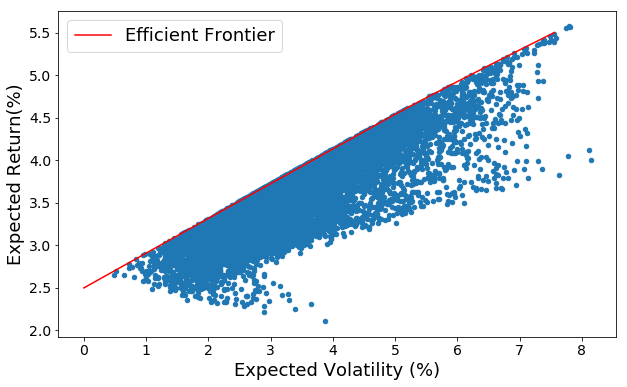

In [69]:
portfolios.plot(x='Volatility', y='Return', kind='scatter', figsize=(10, 6));
plt.plot(std_vector, ret_vector, 'r-', label = 'Efficient Frontier')
plt.xlabel('Expected Volatility (%)', size = 18)
plt.ylabel('Expected Return(%)', size = 18)
plt.legend(fontsize = 18)
plt.tick_params(labelsize=14)

## Demonstrating the two-fund theorem

We will first calculate the requisite asset allocations for a target return, considering only the risky assets. Then we will calculate the asset allocations considering both the risky and the riskless assets. We should observe that the relative weights of the risky assets is unchanged. So any portfolio can be obtained by a combination of the Efficient Portfolio (the Sharpe optimal portfolio) and the Riskless asset.

We have to change the Markowitz function slightly here to output the weights and the volatility.

In [70]:
def Markowitz_weights(num_assets, means_in, covariance_in, r_f, target_ret):
    
    #This is a optimizer function to find the Markowitz efficient portfolio weights (long positions only) for both risky
     #and riskless asset.
    
    #Input: num_assets: number of assets in the portfolio
    #       means_in: numpy vector (1 x num_assets) of the portfolio's mean returns
    #       covariance_in: numpy matrix of the covariances (num_assets x num_assets)
    #       r_f: the risk free rate
    #       target_ret: the target return to be obtained
    #       num_assets: number of assets in the portfolio
    
    ##Output: The target return (target_ret) and the portfolio volatility (sol.fun)
    
    ##Note: The procedure supports long positions only

    x_init = np.ones([num_assets])/num_assets

    def constraint_1(w):
        w_2 = w[0:num_assets-1]
        return np.dot(means_in,w_2) + r_f*w[num_assets-1] - target_ret

    def constraint_2(w):
        return np.sum(w) - 1.0

    def objective(w):
        w_2 = w[0:num_assets-1]
        return 100.0*np.sqrt(np.dot(w_2,np.dot(covariance_in, w_2.T)))

    con1 = {'type':'eq', 'fun': constraint_1}
    con2 = {'type':'eq', 'fun': constraint_2}
    
    cons = [con1,con2]
    
    b = (0.0,1.0)
    bnds = (b,b,b,b)

    sol = sp.minimize(objective, x_init, method = 'SLSQP', bounds=bnds, constraints = cons)
    
    return(target_ret, sol.fun, sol.x)

In [74]:
target_ret_1 = 2.9
w1 = Markowitz_weights(num_assets, ret_array, cov_matrix, r_f, target_ret_1)[2][0]
w2 = Markowitz_weights(num_assets, ret_array, cov_matrix, r_f, target_ret_1)[2][1]
w3 = Markowitz_weights(num_assets, ret_array, cov_matrix, r_f, target_ret_1)[2][2]

asset_1 = w1/(w1+w2+w3)
asset_2 = w2/(w1+w2+w3)
asset_3 = w3/(w1+w2+w3)

print(asset_1,asset_2,asset_3)
print(w3)

0.5440002252039419 0.3599984408782415 0.09600133391781664
0.020556991545176647


In [87]:
sample_returns = np.linspace(2.6, 4.5, num=200, endpoint=True)
asset_weights = [Markowitz_weights(num_assets, ret_array, cov_matrix, r_f, ret)[2] for ret in sample_returns]

In [89]:
for ret in sample_returns:
    w1 = Markowitz_weights(num_assets, ret_array, cov_matrix, r_f, ret)[2][0]
    w2 = Markowitz_weights(num_assets, ret_array, cov_matrix, r_f, ret)[2][1]
    w3 = Markowitz_weights(num_assets, ret_array, cov_matrix, r_f, ret)[2][2]
    
    asset_1 = w1/(w1+w2+w3)
    asset_2 = w2/(w1+w2+w3)
    asset_3 = w3/(w1+w2+w3)
    
    print(ret,asset_1,asset_2,asset_3)
    

2.6 0.5454460487525425 0.35897284669700275 0.09558110455045486
2.6095477386934673 0.5439990769822773 0.3600006438986819 0.09600027911904067
2.6190954773869346 0.5443865919443507 0.35996936904263127 0.09564403901301793
2.6286432160804023 0.5439464879977113 0.3600090991721875 0.0960444128301013
2.6381909547738696 0.5440549886630113 0.3597119950043078 0.09623301633268085
2.647738693467337 0.5438862717303234 0.3599223910123699 0.09619133725730675
2.657286432160804 0.543921332293981 0.35994836718962114 0.09613030051639777
2.6668341708542713 0.5439446563796341 0.3599610132999755 0.09609433032039057
2.6763819095477386 0.5439618886655754 0.35997369292970494 0.09606441840471967
2.6859296482412063 0.5439691639916499 0.3599786865205212 0.0960521494878291
2.6954773869346735 0.5439749120856324 0.3599824176574373 0.09604267025693024
2.705025125628141 0.5439795550654138 0.3599852392014479 0.09603520573313823
2.714572864321608 0.5439833507870123 0.3599874074843661 0.09602924172862164
2.724120603015075

3.64070351758794 0.5439538726177711 0.36004157896517863 0.0960045484170503
3.650251256281407 0.5439406078347103 0.36005964140540225 0.09599975075988756
3.6597989949748744 0.5439366937243106 0.36007197768590954 0.09599132858977985
3.6693467336683416 0.543941928858804 0.3600776823902046 0.09598038875099148
3.678894472361809 0.5439581548834738 0.36007402399266103 0.0959678211238652
3.6884422110552766 0.5439821129441008 0.3600621504632665 0.09595573659263262
3.6979899497487434 0.5440116070030757 0.360042229238809 0.09594616375811539
3.707537688442211 0.5440437840204932 0.3600148739935436 0.09594134198596328
3.7170854271356784 0.5440751114803166 0.35998125893975297 0.09594362957993036
3.7266331658291456 0.5441014679685346 0.3599431377619672 0.09595539426949806
3.7361809045226133 0.5441197329018237 0.3599025988197779 0.09597766827839845
3.74572864321608 0.5441262048247065 0.35986146917788153 0.09601232599741208
3.755276381909548 0.5441169886923728 0.3598221489894482 0.09606086231817901
3.764

Therefore we see that the relative weights in the risky assets, 54.4 %, 36 % and 9.6 % are constant across all target returns. This is the efficient portfolio of risky assets, also known as the Sharpe optimal portfolio. For all returns we can optimize between this portfolio and the riskless asset to obtain the minimum variance.  